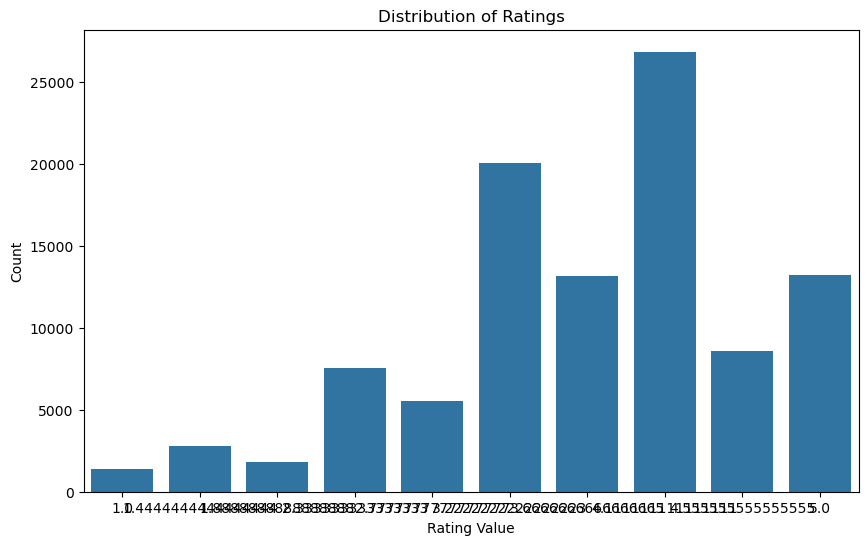

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse


links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')


def prepare_data(ratings_df):
    
    if ratings_df['rating'].max() != 5 or ratings_df['rating'].min() != 1:
        ratings_df['rating'] = ((ratings_df['rating'] - ratings_df['rating'].min()) / 
                              (ratings_df['rating'].max() - ratings_df['rating'].min())) * 4 + 1
    
 
    Tnu = ratings_df['userId'].nunique()
    Tni = ratings_df['movieId'].nunique()
    
    
    ratings_per_product = ratings_df.groupby('movieId')['rating'].count()
    
    return ratings_df, Tnu, Tni, ratings_per_product


def analyze_ratings(ratings_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=ratings_df, x='rating')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating Value')
    plt.ylabel('Count')
    plt.show()
    
    
    total_possible = ratings_df['userId'].nunique() * ratings_df['movieId'].nunique()
    actual_ratings = len(ratings_df)
    sparsity = 1 - (actual_ratings / total_possible)
    
   
    mean_rating = ratings_df['rating'].mean()
    std_rating = ratings_df['rating'].std()
    
    return sparsity, mean_rating, std_rating


def find_target_items(ratings_df, movies_df):
    avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
    lowest_rated = avg_ratings.nsmallest(2)
    target_items = lowest_rated.index.tolist()
    target_names = movies_df[movies_df['movieId'].isin(target_items)]
    return target_items, lowest_rated


class PCAAnalysis:
    def __init__(self, ratings_df, target_items):
        self.ratings_df = ratings_df
        self.target_items = target_items
        self.user_item_matrix = None
        self.mean_filled_matrix = None
        self.item_means = None
        self.covariance_matrix = None
        
    def create_user_item_matrix(self):
        self.user_item_matrix = pd.pivot_table(
            self.ratings_df, 
            values='rating',
            index='userId',
            columns='movieId'
        ).fillna(0)
        
    def calculate_item_means(self):
        self.item_means = self.ratings_df.groupby('movieId')['rating'].mean()
        
    def mean_fill_matrix(self):
        self.mean_filled_matrix = self.user_item_matrix.copy()
        for col in self.mean_filled_matrix.columns:
            mask = self.mean_filled_matrix[col] == 0
            self.mean_filled_matrix.loc[mask, col] = self.item_means[col]
            
    def compute_covariance_matrix(self):
        
        centered_matrix = self.mean_filled_matrix.subtract(self.item_means)
        self.covariance_matrix = centered_matrix.cov()
        
    def find_top_peers(self, target_item, n_peers):
        item_similarities = self.covariance_matrix[target_item].sort_values(ascending=False)
        return item_similarities[1:n_peers+1]
        
    def predict_ratings(self, target_item, n_peers):
        top_peers = self.find_top_peers(target_item, n_peers)
        peer_items = top_peers.index
        
        
        peer_ratings = self.user_item_matrix[peer_items]
        
        
        weights = top_peers / top_peers.sum()
        
        
        predictions = (peer_ratings * weights).sum(axis=1)
        return predictions


ratings_scaled, Tnu, Tni, ratings_per_product = prepare_data(ratings)


sparsity, mean_rating, std_rating = analyze_ratings(ratings_scaled)


target_items, lowest_rated = find_target_items(ratings_scaled, movies)


pca_analysis = PCAAnalysis(ratings_scaled, target_items)
pca_analysis.create_user_item_matrix()
pca_analysis.calculate_item_means()
pca_analysis.mean_fill_matrix()
pca_analysis.compute_covariance_matrix()


results = {}
for target_item in target_items:
    results[target_item] = {
        '5_peers': pca_analysis.predict_ratings(target_item, 5),
        '10_peers': pca_analysis.predict_ratings(target_item, 10)
    }


results_summary = {
    'Tnu': Tnu,
    'Tni': Tni,
    'sparsity': sparsity,
    'mean_rating': mean_rating,
    'std_rating': std_rating,
    'target_items': target_items,
    'predictions': results
}